In [3]:
import numpy as np
import os
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import make_pipeline
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
nltk.download('punkt')
nltk.download('stopwords')
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize


[nltk_data] Downloading package punkt to /Users/yifanwu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yifanwu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:

new_directory = '/Users/yifanwu/Desktop/CSCE915/final_project'
os.chdir(new_directory)
print(os.getcwd())

/Users/yifanwu/Desktop/CSCE915/final_project


In [5]:
file_path = './IMDB Dataset.csv'

In [6]:
dat = pd.read_csv(file_path)
dat.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
data = dat.iloc[0:10000,:]
data['sentiment'] = data['sentiment'].map({'negative': 0, 'positive': 1})
data.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [8]:

# Function to handle negations
def handle_negation(text):
    negations = ["not", "no", "never", "none", "nothing", "nobody", "neither", "nor", "nowhere", "hardly", "scarcely", "barely", "don’t", "isn’t", "wasn’t", "shouldn’t", "wouldn’t", "couldn’t", "won’t"]
    tokens = word_tokenize(text)
    negated = False
    result = []
    for token in tokens:
        if token in negations:
            negated = not negated
        elif negated:
            result.append("NOT_" + token)
        else:
            result.append(token)
    return ' '.join(result)

# Preprocess text data
def preprocess_text(text):
    # Lowercasing and tokenizing
    text = re.sub(r'<.*?>', ' ', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s]', ' ', text)  # Remove punctuation
    text = text.lower()
    tokens = word_tokenize(text)

    # Stop words removal
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Negation handling
    text = handle_negation(' '.join(tokens))

    # Stemming
    stemmer = PorterStemmer()
    tokens = word_tokenize(text)
    tokens = [stemmer.stem(word) for word in tokens]

    return ' '.join(tokens)

In [9]:
# Apply preprocessing to each review
data['processed_review'] = data['review'].apply(preprocess_text)
data.head(5)

,review,sentiment,processed_review
0,One of the other reviewers has mentioned that ...,1,one review mention watch 1 oz episod hook righ...
1,A wonderful little production. <br /><br />The...,1,wonder littl product film techniqu unassum old...
2,I thought this was a wonderful way to spend ti...,1,thought wonder way spend time hot summer weeke...
3,Basically there's a family where a little boy ...,0,basic famili littl boy jake think zombi closet...
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,petter mattei love time money visual stun film...


In [10]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['review'], data['sentiment'], test_size=0.2, random_state=19)


In [11]:
# Vectorization with TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [12]:
model = SVC(kernel='linear',  probability=True)  # Linear kernel is often used for text
model.fit(X_train_tfidf, y_train)


In [51]:
# Predictions and evaluation
predictions = model.predict(X_test_tfidf)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.90      0.87      0.88       989
           1       0.88      0.90      0.89      1011

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000



In [52]:

prediction_probabilities = model.predict_proba(X_test_tfidf)[:, 1]

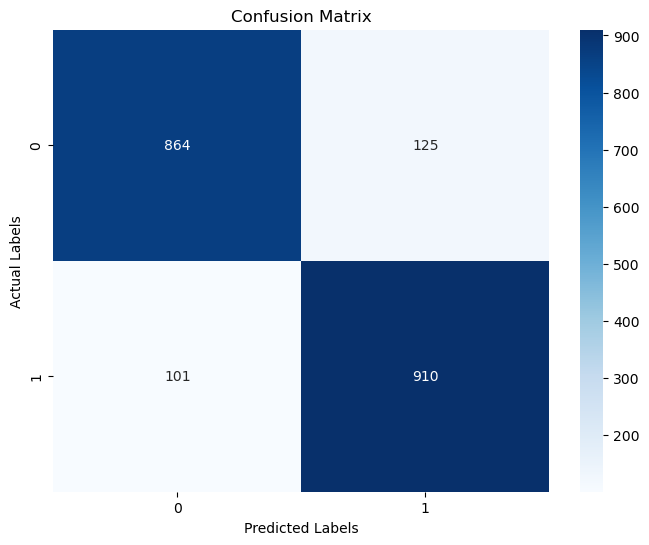

In [53]:

# Confusion Matrix
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()



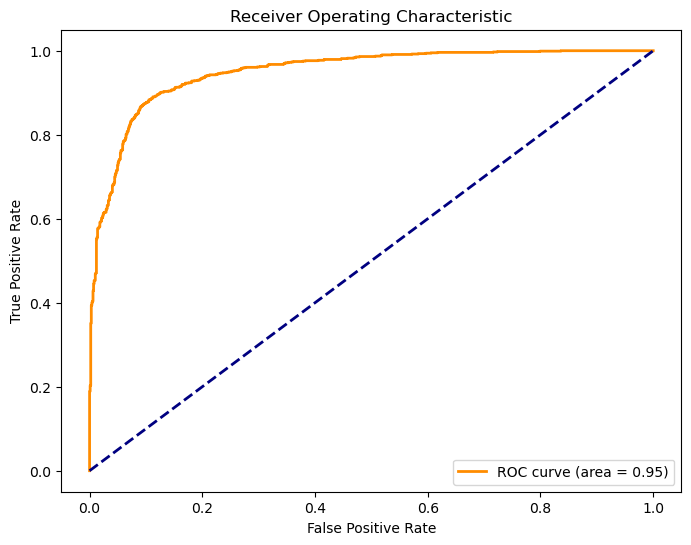

In [54]:
# ROC Curve

fpr, tpr, _ = roc_curve(y_test, prediction_probabilities)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()